In [95]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# --- 1. Settings ---

In [96]:

script_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/scMulti_merged_matrix"
os.chdir(script_dir)
print(f"Working directory set to: {script_dir}")

Working directory set to: /beegfs/scratch/ric.broccoli/kubacki.michal/scMulti_merged_matrix


In [97]:
# Set verbosity to 3 to see more informative output
sc.settings.verbosity = 3
# Set figure parameters
sc.settings.set_figure_params(dpi=80, facecolor='white')

# --- 2. Load Data ---

In [98]:
print("Loading data...")
data_dir = 'filtered_feature_bc_matrix/'
adata = sc.read_10x_mtx(
    data_dir,
    var_names='gene_symbols',
    cache=True)

Loading data...
... reading from cache file cache/filtered_feature_bc_matrix-matrix.h5ad


In [99]:
adata.var_names_make_unique()

In [100]:
print("Data loaded successfully.")
print(adata)

Data loaded successfully.
AnnData object with n_obs × n_vars = 10395 × 32285
    var: 'gene_ids', 'feature_types'


In [101]:
import re

# Check if SNRPN and snord116 genes are present in the dataset
target_genes = ['SNRPN', 'snord116', 'Snrpn', 'Snord116']
target_patterns = ['SNRPN*', 'snord116*', 'Snrpn*', 'Snord116*']  # Patterns to check
available_genes = []
pattern_matches = {}

print("\nChecking for target genes in the dataset...")

# Check exact matches
for gene in target_genes:
    if gene in adata.var_names:
        available_genes.append(gene)
        print(f"Found exact match: {gene}")
    else:
        print(f"Not found: {gene}")

print("\nChecking for pattern matches...")

# Check regex patterns
for pattern in target_patterns:
    # Convert glob pattern to regex (replace * with .*)
    regex_pattern = pattern.replace('*', '.*')
    # Create regex object (case-sensitive by default)
    regex = re.compile(f'^{regex_pattern}$')
    
    # Find all matching genes
    matches = [gene for gene in adata.var_names if regex.match(gene)]
    
    if matches:
        pattern_matches[pattern] = matches
        print(f"\nPattern '{pattern}' matches:")
        for match in matches:
            print(f"  - {match}")
            if match not in available_genes:
                available_genes.append(match)
    else:
        print(f"\nNo matches for pattern: {pattern}")

print(f"\nTotal unique genes found: {len(available_genes)}")
print(f"All found genes: {available_genes}")


Checking for target genes in the dataset...
Not found: SNRPN
Not found: snord116
Found exact match: Snrpn
Not found: Snord116

Checking for pattern matches...

No matches for pattern: SNRPN*

No matches for pattern: snord116*

Pattern 'Snrpn*' matches:
  - Snrpn

No matches for pattern: Snord116*

Total unique genes found: 1
All found genes: ['Snrpn']


In [102]:
# Also search for partial matches
print("\nSearching for genes containing 'snrpn' or 'snord'...")
snrpn_like = adata.var_names[adata.var_names.str.contains('snrpn', case=False, na=False)]
snord_like = adata.var_names[adata.var_names.str.contains('snord', case=False, na=False)]

if len(snrpn_like) > 0:
    print(f"SNRPN-like genes found: {list(snrpn_like)}")
    available_genes.extend(snrpn_like)
if len(snord_like) > 0:
    print(f"SNORD-like genes found: {list(snord_like)}")
    available_genes.extend(snord_like)


Searching for genes containing 'snrpn' or 'snord'...
SNRPN-like genes found: ['Snrpn']


In [103]:
# Remove duplicates
available_genes = list(set(available_genes))
available_genes

['Snrpn']

# --- 3. Preprocessing and Quality Control (QC) ---


Starting preprocessing and QC...
normalizing counts per cell
    finished (0:00:00)


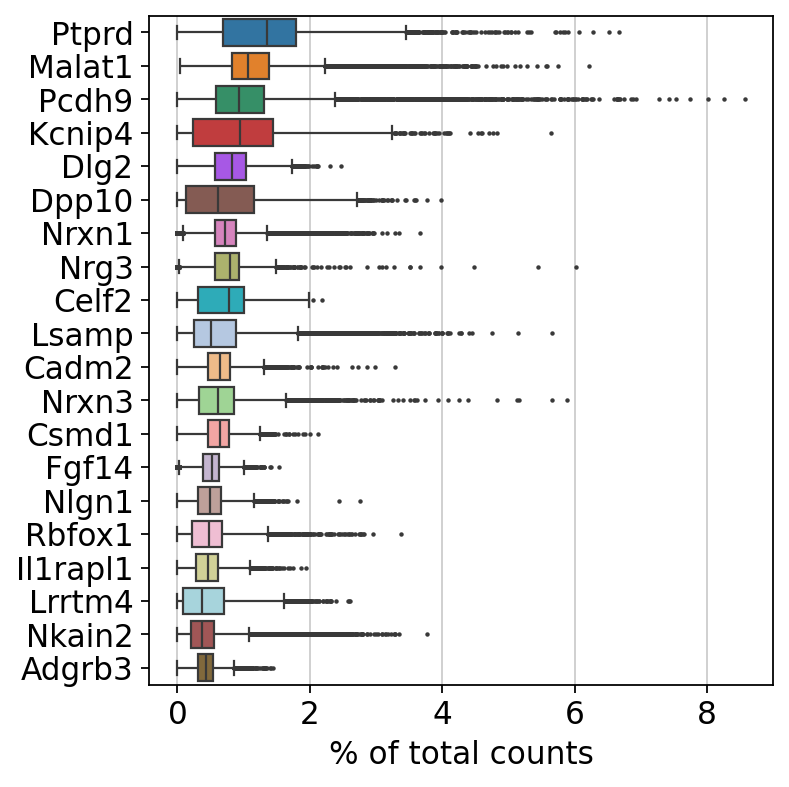

In [104]:
print("\nStarting preprocessing and QC...")

# Show genes that have the highest expression in absolute counts, per cell
sc.pl.highest_expr_genes(adata, n_top=20, save='_highest_expr_genes.png')

In [105]:
# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Store original cell count
n_cells_before = adata.n_obs
print(f"Starting with {n_cells_before} cells")

Starting with 10395 cells


In [106]:
# ========== PERCENTILE-BASED FILTERING ==========

# Calculate percentiles for each QC metric
# Using 2.5th and 97.5th percentiles to remove extreme 5% of cells
n_genes_lower = np.percentile(adata.obs['n_genes_by_counts'], 2.5)
n_genes_upper = np.percentile(adata.obs['n_genes_by_counts'], 97.5)

# Total counts (UMIs)
counts_lower = np.percentile(adata.obs['total_counts'], 2.5)
counts_upper = np.percentile(adata.obs['total_counts'], 97.5)

# Mitochondrial percentage
mt_upper = 20

print("Percentile-based thresholds:")
print(f"  Number of genes: {n_genes_lower:.0f} - {n_genes_upper:.0f}")
print(f"  Total counts: {counts_lower:.0f} - {counts_upper:.0f}")
print(f"  Mitochondrial %: < {mt_upper:.2f}%")

# Count cells that will be filtered by each criterion
n_genes_filter = (adata.obs['n_genes_by_counts'] < n_genes_lower) | (adata.obs['n_genes_by_counts'] > n_genes_upper)
counts_filter = (adata.obs['total_counts'] < counts_lower) | (adata.obs['total_counts'] > counts_upper)
mt_filter = adata.obs['pct_counts_mt'] > mt_upper

print(f"\nCells filtered by each criterion:")
print(f"  n_genes: {n_genes_filter.sum()} cells")
print(f"  total_counts: {counts_filter.sum()} cells")
print(f"  pct_counts_mt: {mt_filter.sum()} cells")

Percentile-based thresholds:
  Number of genes: 1555 - 11259
  Total counts: 2969 - 230975
  Mitochondrial %: < 20.00%

Cells filtered by each criterion:
  n_genes: 517 cells
  total_counts: 520 cells
  pct_counts_mt: 0 cells



After filtering: 9800 cells
Removed 595 cells (5.7%)

Filtering genes expressed in < 3 cells...
Removed 6009 genes


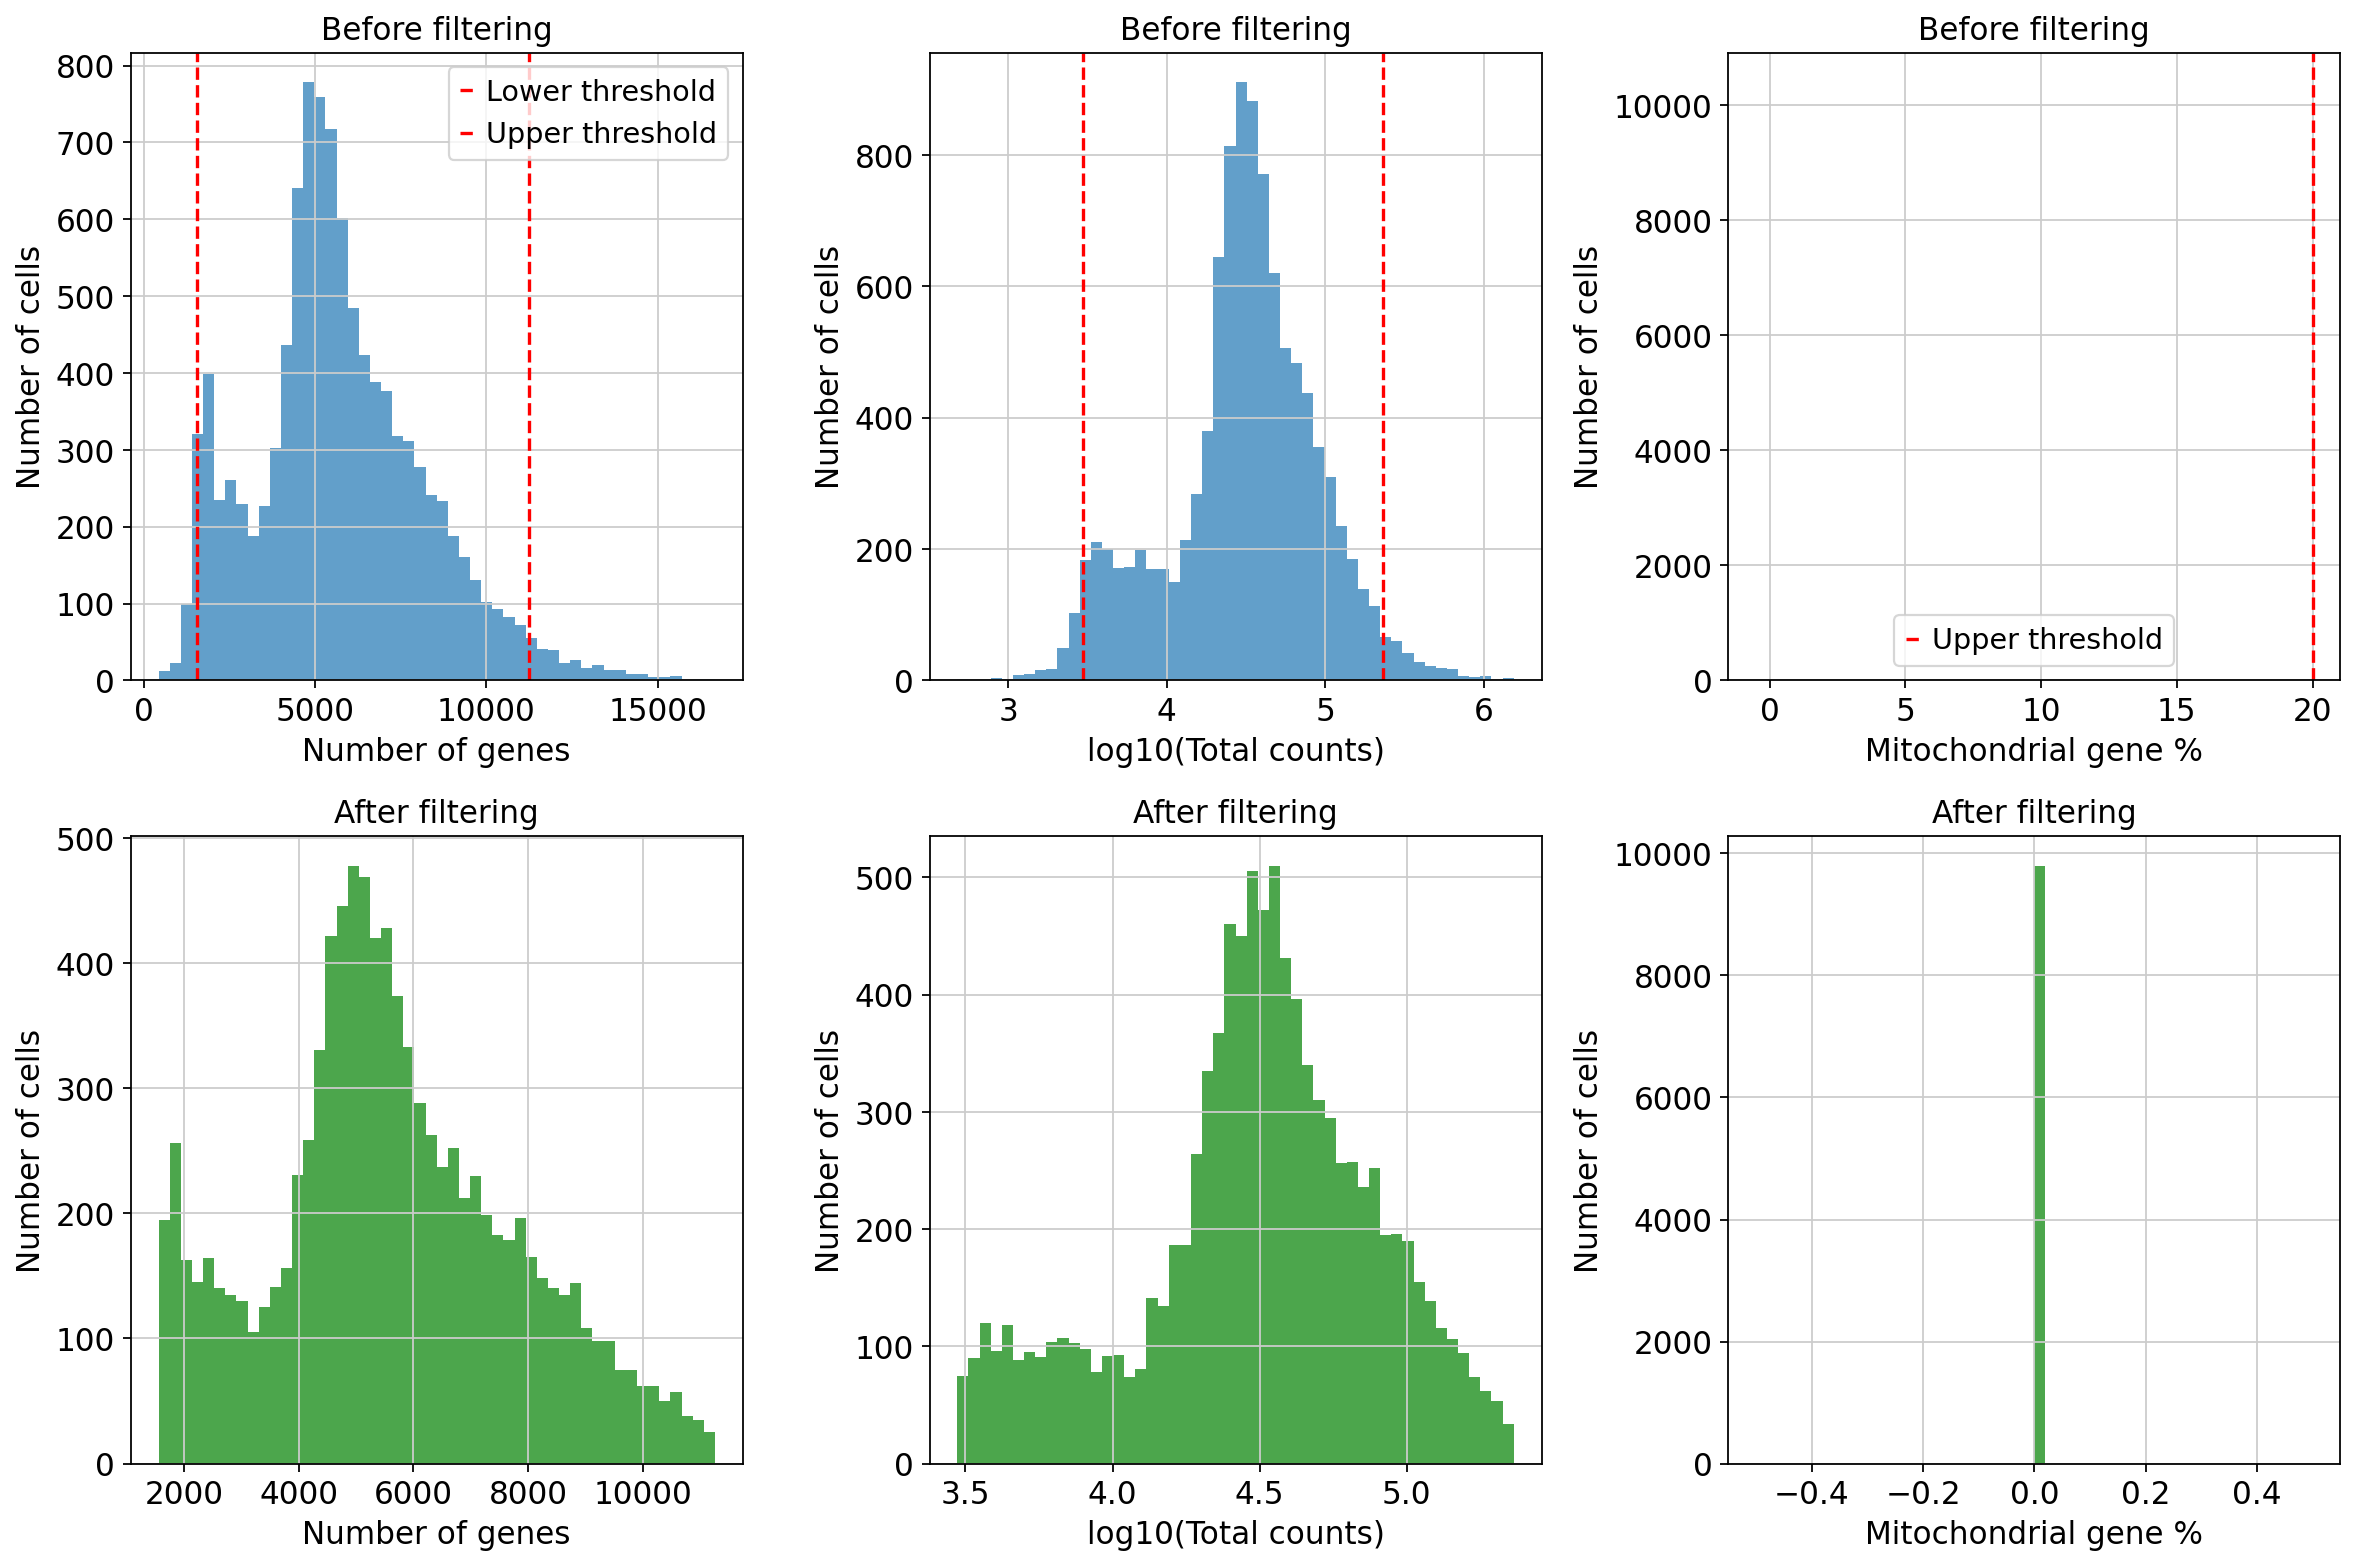

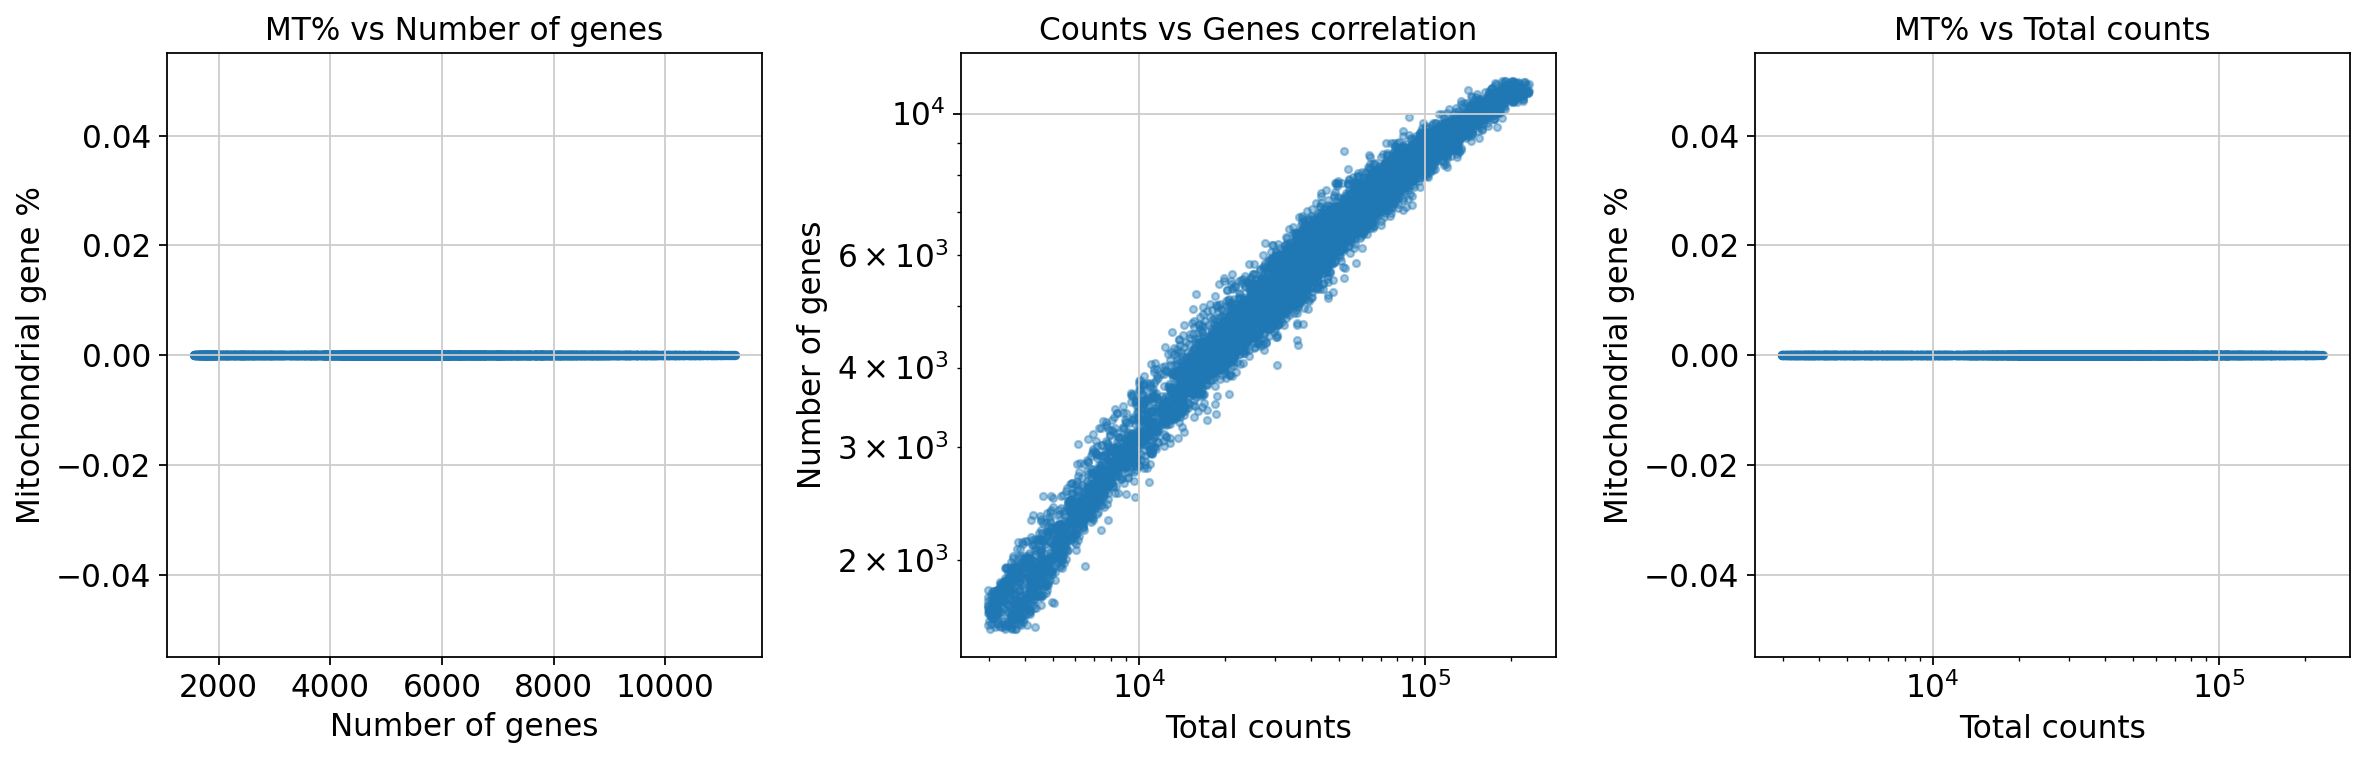

In [107]:
# ========== VISUALIZATION ==========

# Save original QC metrics before filtering for visualization
orig_n_genes = adata.obs['n_genes_by_counts'].copy()
orig_total_counts = adata.obs['total_counts'].copy()
orig_pct_mt = adata.obs['pct_counts_mt'].copy()

# Apply all filters
keep_cells = (
    (adata.obs['n_genes_by_counts'] >= n_genes_lower) & 
    (adata.obs['n_genes_by_counts'] <= n_genes_upper) & 
    (adata.obs['total_counts'] >= counts_lower) & 
    (adata.obs['total_counts'] <= counts_upper) & 
    (adata.obs['pct_counts_mt'] <= mt_upper)
)

# Filter the data
adata = adata[keep_cells, :].copy()

n_cells_after = adata.n_obs
print(f"\nAfter filtering: {n_cells_after} cells")
print(f"Removed {n_cells_before - n_cells_after} cells ({100*(n_cells_before - n_cells_after)/n_cells_before:.1f}%)")

# Filter genes expressed in very few cells
min_cells = 3
print(f"\nFiltering genes expressed in < {min_cells} cells...")
n_genes_before_filter = adata.n_vars
# Keep genes that are in at least min_cells cells OR are in our list of available_genes
genes_to_keep = (adata.var['n_cells_by_counts'] >= min_cells) | (adata.var_names.isin(available_genes))
adata = adata[:, genes_to_keep].copy()
n_genes_after_filter = adata.n_vars
print(f"Removed {n_genes_before_filter - n_genes_after_filter} genes")

# Create figure with QC plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Before filtering
axes[0, 0].hist(orig_n_genes, bins=50, alpha=0.7)
axes[0, 0].axvline(n_genes_lower, color='red', linestyle='--', label='Lower threshold')
axes[0, 0].axvline(n_genes_upper, color='red', linestyle='--', label='Upper threshold')
axes[0, 0].set_xlabel('Number of genes')
axes[0, 0].set_ylabel('Number of cells')
axes[0, 0].set_title('Before filtering')
axes[0, 0].legend()

axes[0, 1].hist(np.log10(orig_total_counts), bins=50, alpha=0.7)
axes[0, 1].axvline(np.log10(counts_lower), color='red', linestyle='--')
axes[0, 1].axvline(np.log10(counts_upper), color='red', linestyle='--')
axes[0, 1].set_xlabel('log10(Total counts)')
axes[0, 1].set_ylabel('Number of cells')
axes[0, 1].set_title('Before filtering')

axes[0, 2].hist(orig_pct_mt, bins=50, alpha=0.7)
axes[0, 2].axvline(mt_upper, color='red', linestyle='--', label='Upper threshold')
axes[0, 2].set_xlabel('Mitochondrial gene %')
axes[0, 2].set_ylabel('Number of cells')
axes[0, 2].set_title('Before filtering')
axes[0, 2].legend()

# Row 2: After filtering
axes[1, 0].hist(adata.obs['n_genes_by_counts'], bins=50, alpha=0.7, color='green')
axes[1, 0].set_xlabel('Number of genes')
axes[1, 0].set_ylabel('Number of cells')
axes[1, 0].set_title('After filtering')

axes[1, 1].hist(np.log10(adata.obs['total_counts']), bins=50, alpha=0.7, color='green')
axes[1, 1].set_xlabel('log10(Total counts)')
axes[1, 1].set_ylabel('Number of cells')
axes[1, 1].set_title('After filtering')

axes[1, 2].hist(adata.obs['pct_counts_mt'], bins=50, alpha=0.7, color='green')
axes[1, 2].set_xlabel('Mitochondrial gene %')
axes[1, 2].set_ylabel('Number of cells')
axes[1, 2].set_title('After filtering')

plt.tight_layout()
plt.savefig('figures/qc_histograms_before_after.png', dpi=300, bbox_inches='tight')
plt.show()

# Create scatter plots to show relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MT% vs n_genes
axes[0].scatter(adata.obs['n_genes_by_counts'], adata.obs['pct_counts_mt'], 
                alpha=0.4, s=10)
axes[0].set_xlabel('Number of genes')
axes[0].set_ylabel('Mitochondrial gene %')
axes[0].set_title('MT% vs Number of genes')

# Total counts vs n_genes (log scale)
axes[1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], 
                alpha=0.4, s=10)
axes[1].set_xlabel('Total counts')
axes[1].set_ylabel('Number of genes')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Counts vs Genes correlation')

# MT% vs total counts
axes[2].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], 
                alpha=0.4, s=10)
axes[2].set_xlabel('Total counts')
axes[2].set_ylabel('Mitochondrial gene %')
axes[2].set_xscale('log')
axes[2].set_title('MT% vs Total counts')

plt.tight_layout()
plt.savefig('figures/qc_scatter_filtered.png', dpi=300, bbox_inches='tight')
plt.show()

In [108]:
# ========== SUMMARY STATISTICS ==========

# Create summary DataFrame
summary_stats = pd.DataFrame({
    'Metric': ['Total cells (initial)', 'Total cells (filtered)', 'Cells removed', 
               'Percent cells removed', 'Total genes (initial)', 'Total genes (filtered)',
               'n_genes threshold (lower)', 'n_genes threshold (upper)',
               'total_counts threshold (lower)', 'total_counts threshold (upper)',
               'MT% threshold'],
    'Value': [n_cells_before, n_cells_after, n_cells_before - n_cells_after,
              f"{100*(n_cells_before - n_cells_after)/n_cells_before:.1f}%",
              n_genes_before_filter, n_genes_after_filter,
              f"{n_genes_lower:.0f}", f"{n_genes_upper:.0f}",
              f"{counts_lower:.0f}", f"{counts_upper:.0f}",
              f"{mt_upper:.2f}%"]
})

print("\n" + "="*50)
print("FILTERING SUMMARY")
print("="*50)
print(summary_stats.to_string(index=False))

# Save the summary to file
summary_stats.to_csv('qc_filtering_summary.csv', index=False)

# Optional: Save the filtered data
# adata.write('filtered_adata.h5ad')
print("\nFiltered data is ready for downstream analysis!")


FILTERING SUMMARY
                        Metric  Value
         Total cells (initial)  10395
        Total cells (filtered)   9800
                 Cells removed    595
         Percent cells removed   5.7%
         Total genes (initial)  32285
        Total genes (filtered)  26276
     n_genes threshold (lower)   1555
     n_genes threshold (upper)  11259
total_counts threshold (lower)   2969
total_counts threshold (upper) 230975
                 MT% threshold 20.00%

Filtered data is ready for downstream analysis!


# --- 4. Normalization and Feature Selection ---


Normalizing data and selecting highly variable genes...
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


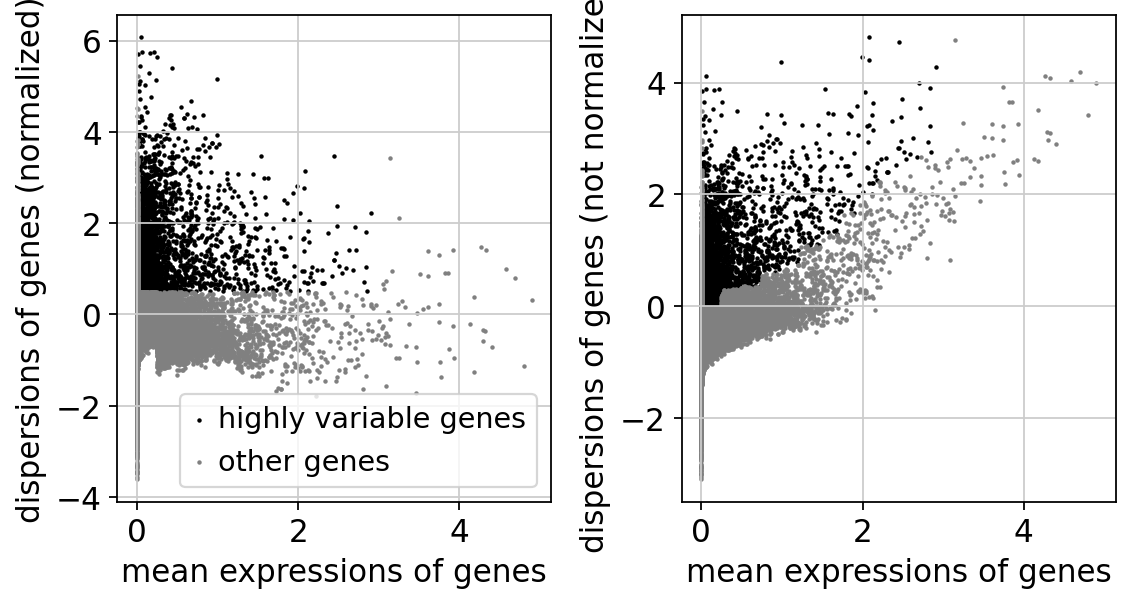

Ensuring 1 available genes are not filtered out as non-highly-variable.
Finished normalization and feature selection.


In [109]:
print("\nNormalizing data and selecting highly variable genes...")

# Normalize each cell by total counts over all genes, so that every cell has the same total count.
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, save='_highly_variable_genes.png')

# Add available_genes to the list of highly variable genes to keep them from being filtered out
print(f"Ensuring {len(available_genes)} available genes are not filtered out as non-highly-variable.")
adata.var.loc[adata.var_names.isin(available_genes), 'highly_variable'] = True

# Slice the AnnData object to keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

print("Finished normalization and feature selection.")

# --- 5. Dimensionality Reduction ---


Performing dimensionality reduction...
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/beegfs/scratch/ric.broccoli/kubacki.michal/conda/envs/bioinf/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=50
    finished (0:00:00)


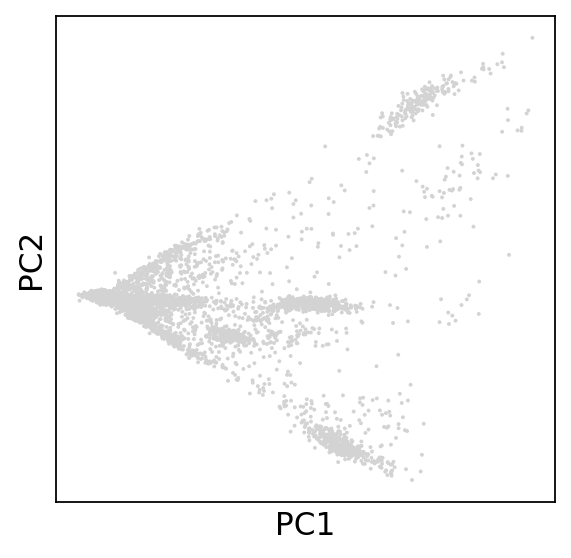

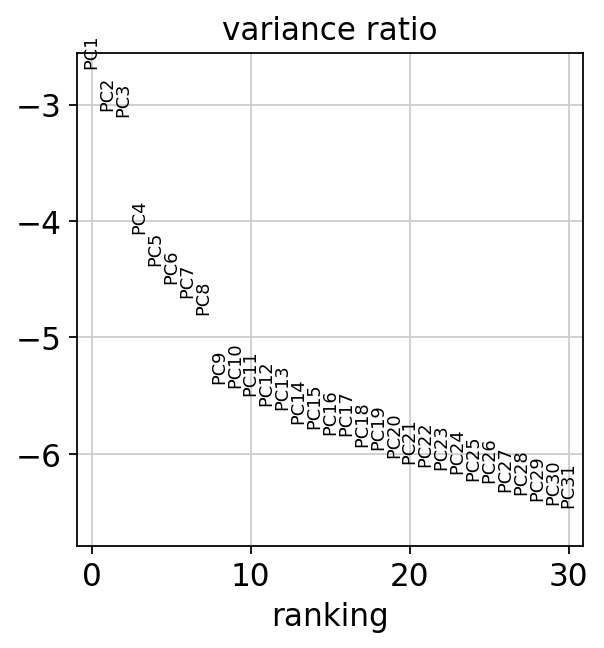

In [110]:
print("\nPerforming dimensionality reduction...")

# Scale the data to unit variance and zero mean
sc.pp.scale(adata, max_value=10)

# Principal component analysis (PCA)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, save='_pca.png')
sc.pl.pca_variance_ratio(adata, log=True, save='_pca_variance_ratio.png')

# --- 6. Clustering and Visualization ---


Clustering and visualization...
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)


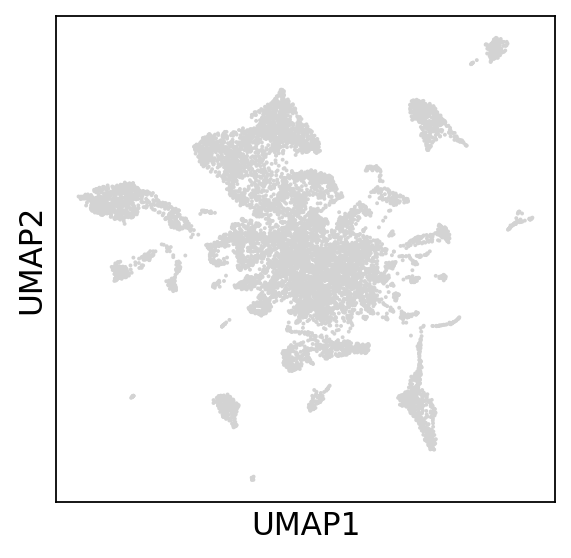

running Leiden clustering
    finished: found 41 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


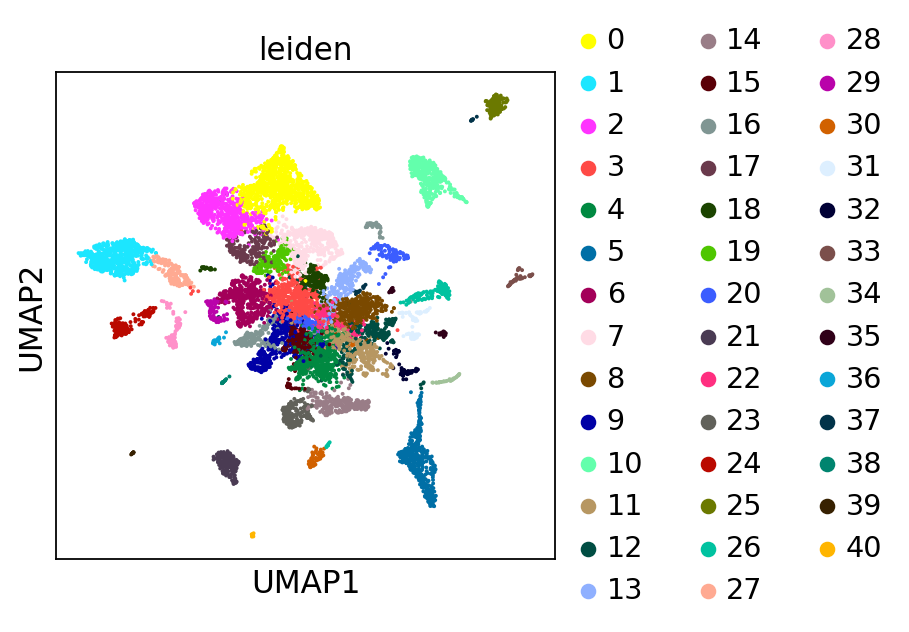

In [111]:
print("\nClustering and visualization...")

# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Embedding the neighborhood graph using UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, save='_umap_markers.png')

# Clustering the neighborhood graph using the Leiden algorithm
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'], save='_umap_leiden.png')

# --- 7. Add alternative UMAP projection ---


Adding alternative UMAP projection from CSV...


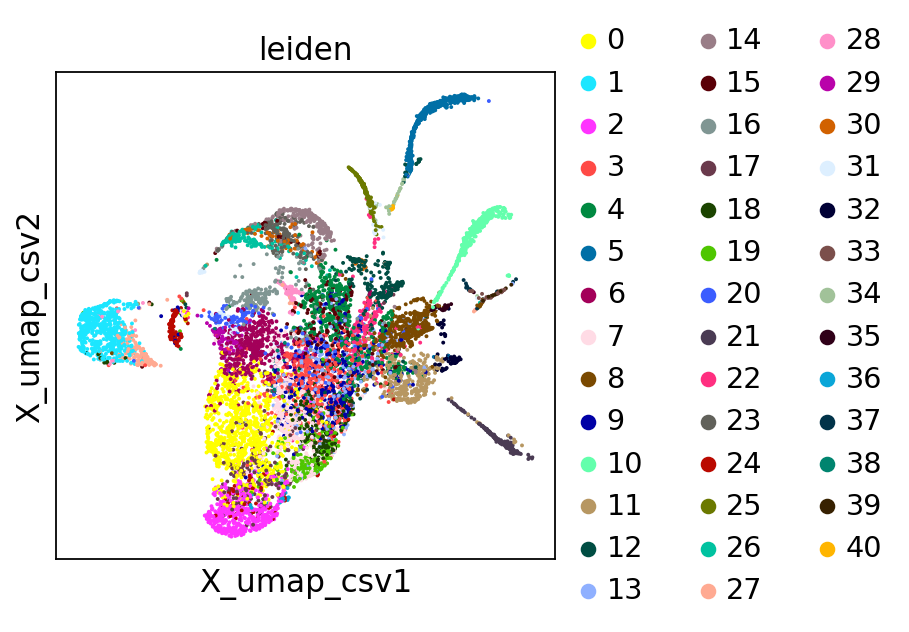

In [112]:
print("\nAdding alternative UMAP projection from CSV...")

# Load the external UMAP projection
umap_df = pd.read_csv('umap_projection.csv', index_col=0)

# Align the dataframes by index (barcodes)
aligned_df = umap_df.reindex(adata.obs_names)

# Add the UMAP coordinates to the AnnData object
adata.obsm['X_umap_csv'] = aligned_df[['UMAP-1', 'UMAP-2']].values

# Plot the new UMAP projection
sc.pl.embedding(adata, basis='X_umap_csv', color=['leiden'], save='_umap_csv_leiden.png')

# --- 8. Add Metadata from the Downloaded CSV File ---

In [113]:
metadata_csv_file = './LibraryID.csv'

In [114]:
print(f"\n--- Step 8: Loading metadata from '{metadata_csv_file}' ---")
metadata_df = pd.read_csv(metadata_csv_file)
metadata_df.set_index('Barcode', inplace=True)
adata.obs = adata.obs.join(metadata_df)

if 'LibraryID' not in adata.obs.columns:
    raise ValueError("'LibraryID' column not found after loading CSV.")
if adata.obs['LibraryID'].isnull().any():
    n_missing = adata.obs['LibraryID'].isnull().sum()
    print(f"WARNING: {n_missing} cells did not have a matching barcode in the CSV file.")

print("\nSuccessfully added metadata from CSV. New adata.obs:")
print(adata.obs.head())


--- Step 8: Loading metadata from './LibraryID.csv' ---

Successfully added metadata from CSV. New adata.obs:
                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACAGCCACATAACT-1               4640       22785.0              0.0   
AAACAGCCACCCACAG-1               5179       33590.0              0.0   
AAACAGCCAGCAAATA-1               4960       25106.0              0.0   
AAACAGCCATCAATCG-2               6434       41290.0              0.0   
AAACAGCCATGAATCT-2               4120       20154.0              0.0   

                    pct_counts_mt leiden               LibraryID  
AAACAGCCACATAACT-1            0.0     28  Ube3a_mut_brain_cortex  
AAACAGCCACCCACAG-1            0.0      2  Ube3a_mut_brain_cortex  
AAACAGCCAGCAAATA-1            0.0     24  Ube3a_mut_brain_cortex  
AAACAGCCATCAATCG-2            0.0      8         WT_brain_cortex  
AAACAGCCATGAATCT-2            0.0      2         WT_brain_cortex  


# --- Save Results ---

In [115]:
print("\nAnalysis complete. Results saved to 'figures/' directory.")
print("Final AnnData object:")
print(adata)

# Save the final AnnData object
adata.write('processed_data.h5ad')
print("\nProcessed data saved to 'processed_data.h5ad'")


Analysis complete. Results saved to 'figures/' directory.
Final AnnData object:
AnnData object with n_obs × n_vars = 9800 × 3622
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'LibraryID'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_csv'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Processed data saved to 'processed_data.h5ad'


# --- 9. Subset to Wild-Type Nuclei and Analyze SNRPN/snord116 Expression ---

In [116]:
print("\n--- Step 9: Subsetting to wild-type nuclei and analyzing SNRPN/snord116 expression ---")

# Check available LibraryID categories
print("Available LibraryID categories:")
print(adata.obs['LibraryID'].value_counts())

# Subset to wild-type nuclei only
print("\nSubsetting to wild-type nuclei (WT_brain_cortex)...")
wt_mask = adata.obs['LibraryID'] == 'WT_brain_cortex'
adata_wt = adata[wt_mask, :].copy()

print(f"Original dataset: {adata.n_obs} cells")
print(f"Wild-type subset: {adata_wt.n_obs} cells")
print(f"Percentage of wild-type cells: {100 * adata_wt.n_obs / adata.n_obs:.1f}%")


--- Step 9: Subsetting to wild-type nuclei and analyzing SNRPN/snord116 expression ---
Available LibraryID categories:
LibraryID
WT_brain_cortex           4988
Ube3a_mut_brain_cortex    4812
Name: count, dtype: int64

Subsetting to wild-type nuclei (WT_brain_cortex)...
Original dataset: 9800 cells
Wild-type subset: 4988 cells
Percentage of wild-type cells: 50.9%



Creating cell-type resolved visualizations...
Creating UMAP plot for Snrpn...


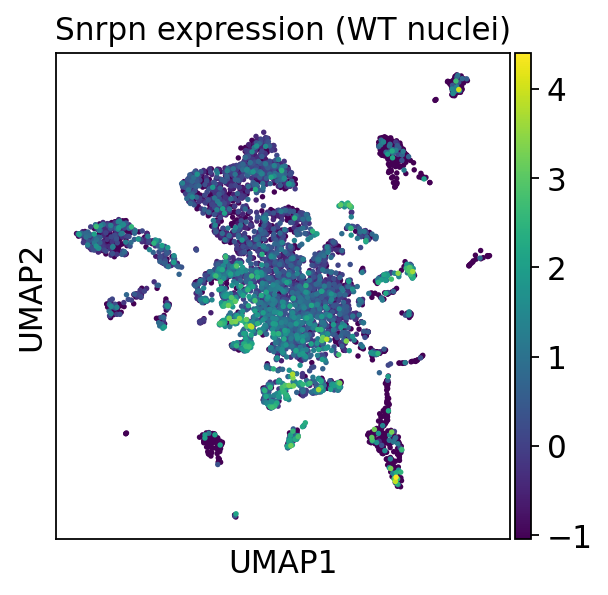

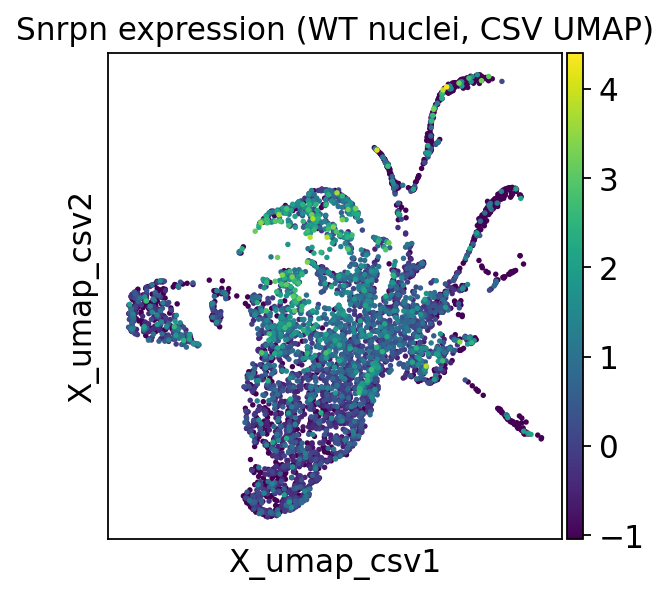

In [117]:
print("\nCreating cell-type resolved visualizations...")
    
# UMAP plots colored by gene expression
for gene in available_genes:
    print(f"Creating UMAP plot for {gene}...")
    
    # Plot on original UMAP
    sc.pl.umap(adata_wt, color=gene, save=f'_wt_{gene}_expression.png',
                title=f'{gene} expression (WT nuclei)')
    
    # Plot on CSV UMAP if available
    if 'X_umap_csv' in adata_wt.obsm.keys():
        sc.pl.embedding(adata_wt, basis='X_umap_csv', color=gene,
                        save=f'_wt_csv_{gene}_expression.png',
                        title=f'{gene} expression (WT nuclei, CSV UMAP)')


Creating dot plot for cluster-resolved expression...


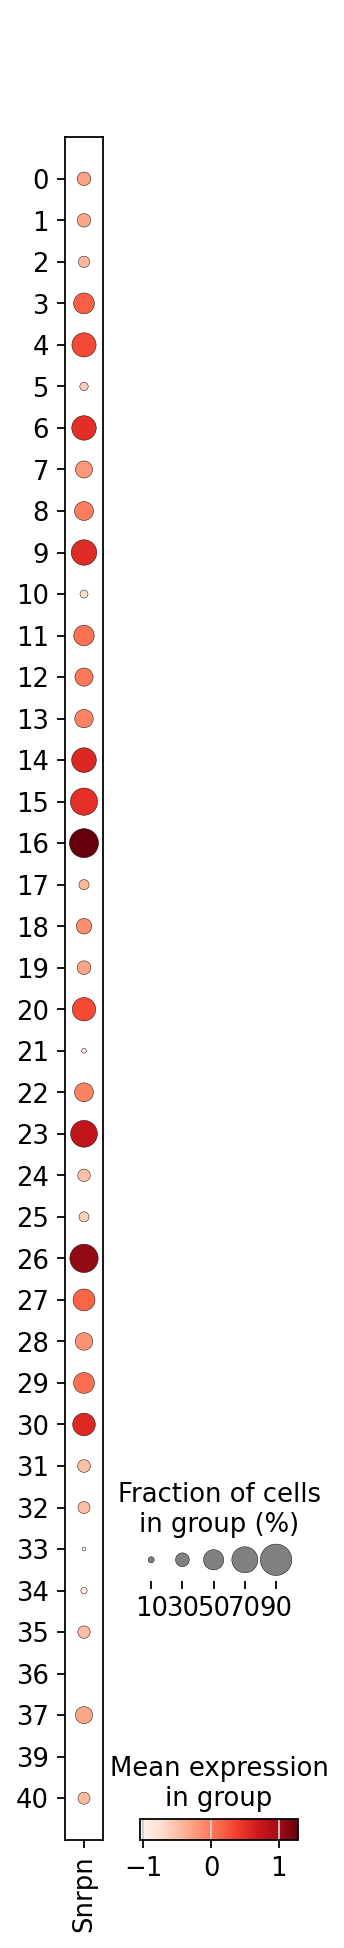

In [118]:
# Create dot plot showing expression across clusters
print("\nCreating dot plot for cluster-resolved expression...")
sc.pl.dotplot(adata_wt, available_genes, groupby='leiden',
                save=f'_wt_snrpn_snord_dotplot.png')


Creating violin plot for cluster-resolved expression...


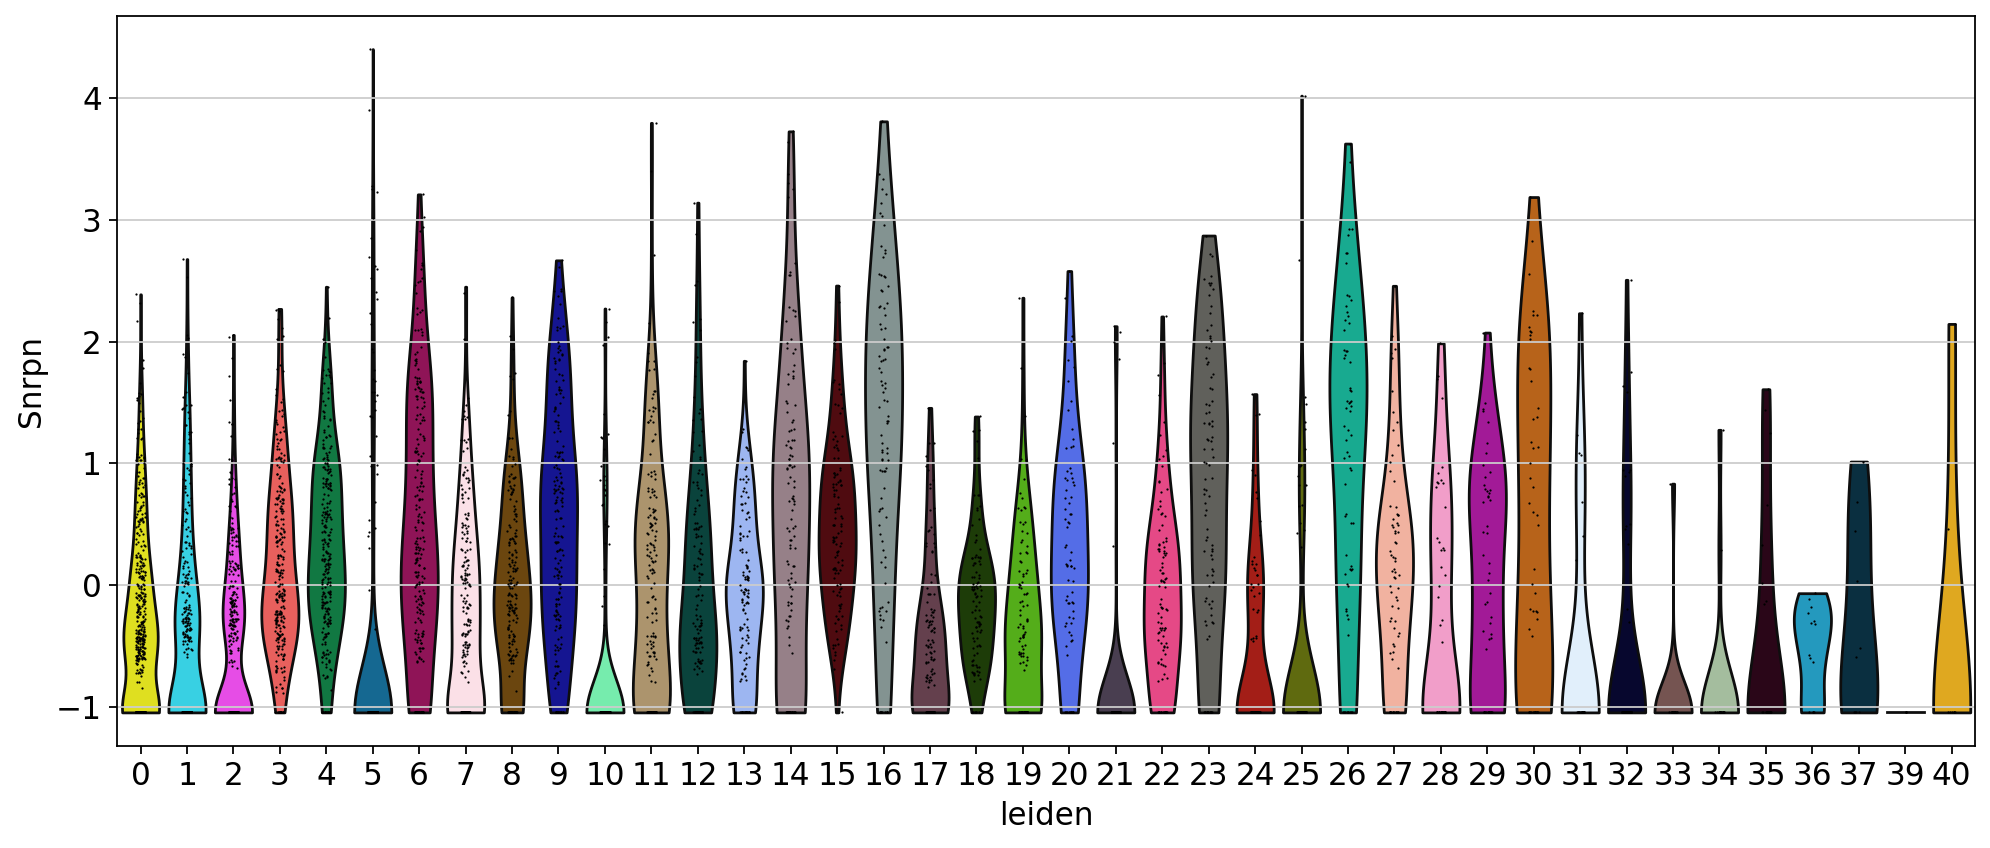

In [119]:
# Create violin plot
print("\nCreating violin plot for cluster-resolved expression...")
sc.settings.set_figure_params(figsize=(12, 6), dpi=80)
sc.pl.violin(adata_wt, available_genes, groupby='leiden',
             save=f'_wt_snrpn_snord_violin.png')

In [124]:
global_max = adata_wt[:, :].X.toarray().flatten().max()
print(f"Global Mean expression: {global_max:.3f}")

Global Mean expression: 10.000


In [120]:
# Summary statistics
print("\nExpression summary statistics (WT nuclei only):")
for gene in available_genes:
    gene_expr = adata_wt[:, gene].X.toarray().flatten()
    expressing_cells = (gene_expr > 0).sum()
    total_cells = len(gene_expr)
    mean_expr = gene_expr.mean()
    max_expr = gene_expr.max()
    
    print(f"{gene}:")
    print(f"  Expressing cells: {expressing_cells}/{total_cells} ({100*expressing_cells/total_cells:.1f}%)")
    print(f"  Mean expression: {mean_expr:.3f}")
    print(f"  Max expression: {max_expr:.3f}")


Expression summary statistics (WT nuclei only):
Snrpn:
  Expressing cells: 2092/4988 (41.9%)
  Mean expression: -0.042
  Max expression: 4.402



Creating comparison between WT and Ube3a mutant...


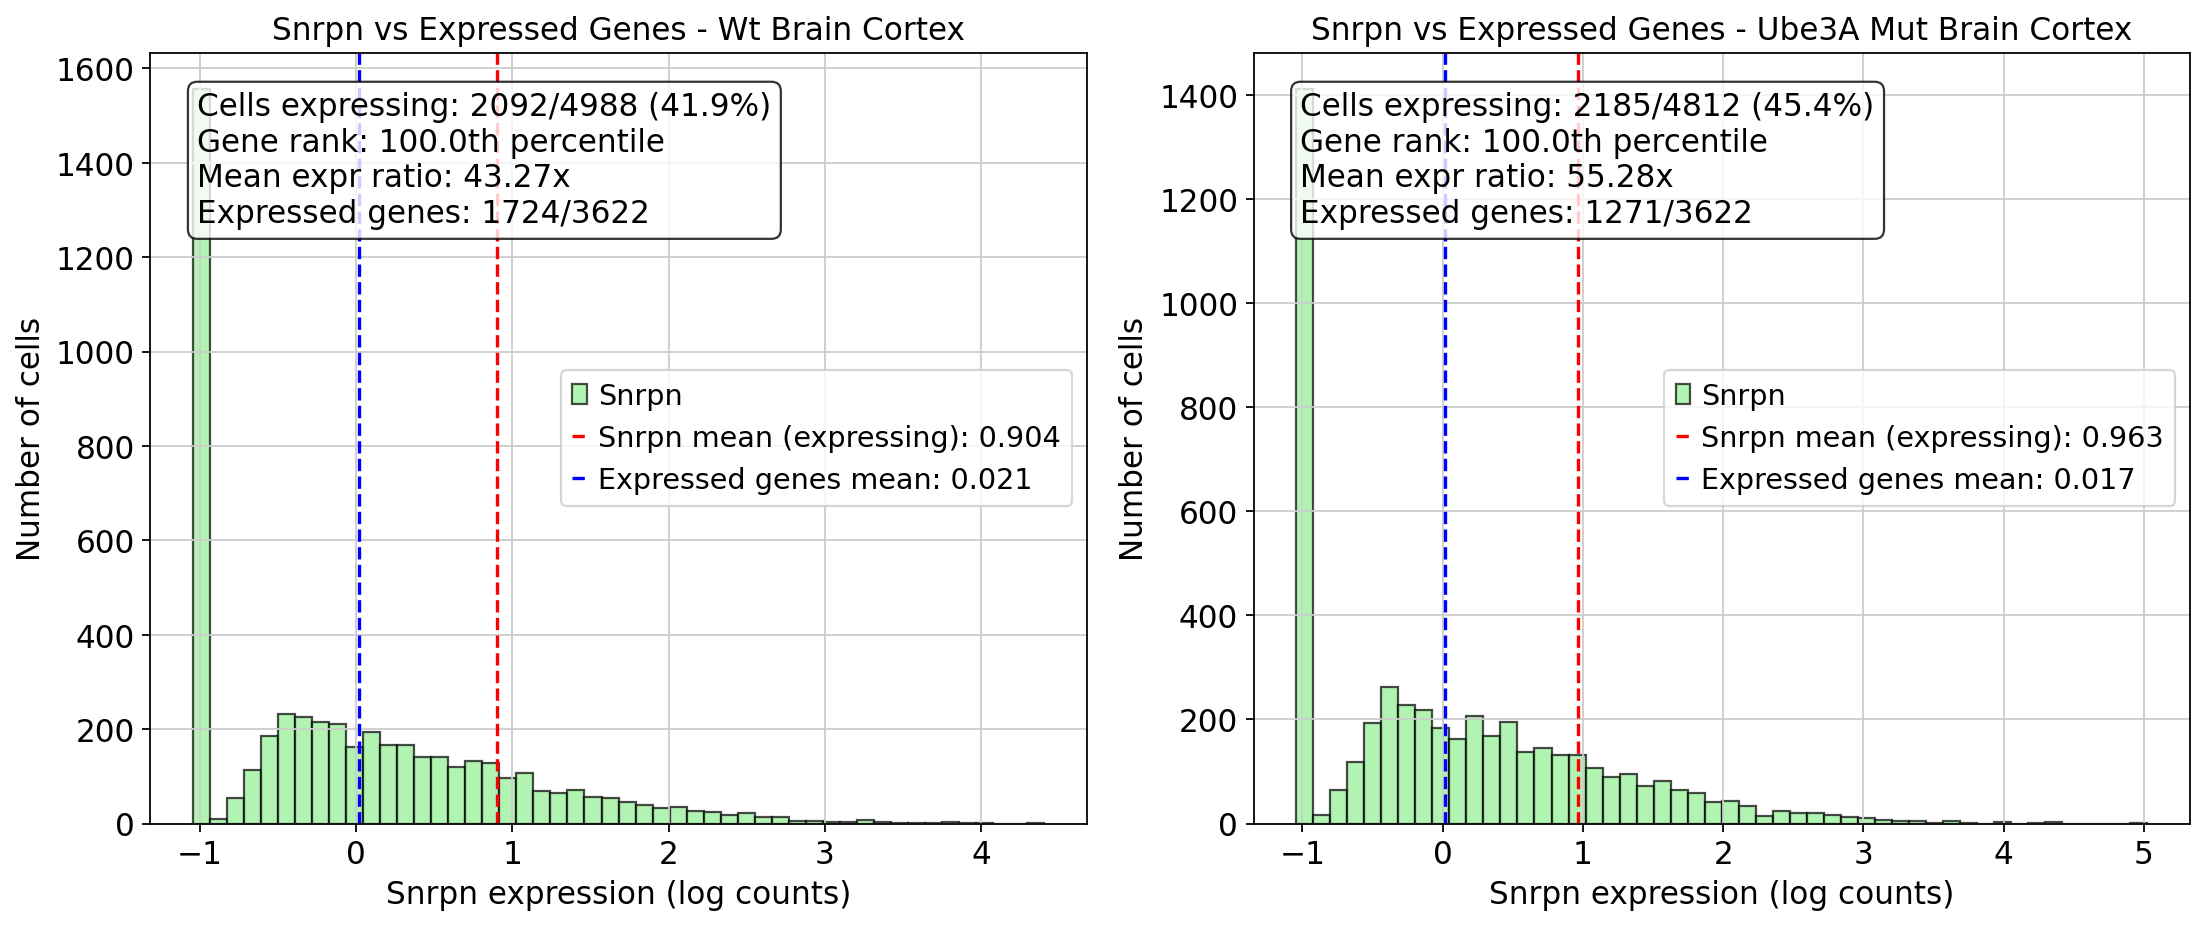

In [121]:
# Create comparison plot between WT and mutant if both are present
print("\nCreating comparison between WT and Ube3a mutant...")

# Create a combined plot for specific gene
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, condition in enumerate(['WT_brain_cortex', 'Ube3a_mut_brain_cortex']):
    condition_mask = adata.obs['LibraryID'] == condition
    adata_condition = adata[condition_mask, :].copy()
    
    # Plot first available gene
    gene = available_genes[0]
    if gene in adata_condition.var_names:
        # Get expression of target gene across ALL cells (including zeros)
        gene_expr = adata_condition[:, gene].X.toarray().flatten()
        
        # Calculate mean expression of all genes, excluding genes with zero expression
        if hasattr(adata_condition.X, 'A1'):
            all_gene_means = np.array(adata_condition.X.mean(axis=0)).flatten()
        else:
            all_gene_means = adata_condition.X.mean(axis=0)
        
        # Filter out genes with zero mean expression
        expressed_genes_means = all_gene_means[all_gene_means > 0]
        
        # Get mean expression of our target gene ONLY in expressing cells
        expressing_cells_mask = gene_expr > 0
        target_gene_mean = np.mean(gene_expr[expressing_cells_mask]) if expressing_cells_mask.sum() > 0 else 0
        
        # Calculate percentile rank of target gene among expressed genes only
        if target_gene_mean > 0:
            gene_rank_percentile = (expressed_genes_means < target_gene_mean).sum() / len(expressed_genes_means) * 100
        else:
            gene_rank_percentile = 0
        
        # Plot histogram of target gene expression across ALL cells
        axes[i].hist(gene_expr, bins=50, alpha=0.7,
                    color='lightgreen', edgecolor='black',
                    label=f'{gene}')
        
        # Add vertical lines for comparison
        if target_gene_mean > 0:
            axes[i].axvline(target_gene_mean, color='red', linestyle='--',
                            label=f'{gene} mean (expressing): {target_gene_mean:.3f}')
        axes[i].axvline(np.mean(expressed_genes_means), color='blue', linestyle='--',
                        label=f'Expressed genes mean: {np.mean(expressed_genes_means):.3f}')
        
        axes[i].set_xlabel(f'{gene} expression (log counts)')
        axes[i].set_ylabel('Number of cells')
        axes[i].set_title(f'{gene} vs Expressed Genes - {condition.replace("_", " ").title()}')
        axes[i].legend()
        
        # Add text with comparison statistics
        expressing_cells = expressing_cells_mask.sum()
        total_cells = len(adata_condition)
        expressing_pct = (expressing_cells / total_cells) * 100
        
        stats_text = f'Cells expressing: {expressing_cells}/{total_cells} ({expressing_pct:.1f}%)\n'
        if target_gene_mean > 0:
            stats_text += f'Gene rank: {gene_rank_percentile:.1f}th percentile\n'
            stats_text += f'Mean expr ratio: {target_gene_mean/np.mean(expressed_genes_means):.2f}x\n'
        else:
            stats_text += f'Gene not expressed\n'
        stats_text += f'Expressed genes: {len(expressed_genes_means)}/{len(all_gene_means)}'
        
        axes[i].text(0.05, 0.95, stats_text,
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(f'figures/wt_vs_mut_{available_genes[0]}_comparison.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [122]:

# Print detailed gene expression comparison
print(f"\nDetailed expression comparison for {available_genes[0]}:")
for condition in ['WT_brain_cortex', 'Ube3a_mut_brain_cortex']:
    condition_mask = adata.obs['LibraryID'] == condition
    adata_condition = adata[condition_mask, :].copy()
    
    if len(adata_condition) > 0:
        gene = available_genes[0]
        if gene in adata_condition.var_names:
            gene_expr = adata_condition[:, gene].X.toarray().flatten()
            
            # Calculate all gene means for comparison, excluding zero-expression genes
            if hasattr(adata_condition.X, 'A1'):
                all_gene_means = np.array(adata_condition.X.mean(axis=0)).flatten()
            else:
                all_gene_means = adata_condition.X.mean(axis=0)
            
            # Filter out genes with zero mean expression
            expressed_genes_means = all_gene_means[all_gene_means > 0]
            
            # Calculate target gene mean only in expressing cells
            expressing_cells_mask = gene_expr > 0
            target_gene_mean = np.mean(gene_expr[expressing_cells_mask]) if expressing_cells_mask.sum() > 0 else 0
            
            if target_gene_mean > 0:
                gene_rank = (expressed_genes_means < target_gene_mean).sum()
                percentile = (gene_rank / len(expressed_genes_means)) * 100
            else:
                gene_rank = 0
                percentile = 0
            
            print(f"\n{condition.replace('_', ' ').title()}:")
            print(f"  Cells expressing {gene}: {expressing_cells_mask.sum()}/{len(gene_expr)} ({expressing_cells_mask.sum()/len(gene_expr)*100:.1f}%)")
            if target_gene_mean > 0:
                print(f"  {gene} mean expression (expressing cells only): {target_gene_mean:.4f}")
                print(f"  Expressed genes mean: {np.mean(expressed_genes_means):.4f}")
                print(f"  {gene} rank among expressed genes: {gene_rank}/{len(expressed_genes_means)} ({percentile:.1f}th percentile)")
                print(f"  Expression ratio vs expressed genes average: {target_gene_mean/np.mean(expressed_genes_means):.2f}x")
            else:
                print(f"  {gene} is not expressed in this condition")
            print(f"  Total genes in dataset: {len(all_gene_means)}")
            print(f"  Expressed genes: {len(expressed_genes_means)} ({len(expressed_genes_means)/len(all_gene_means)*100:.1f}%)")


Detailed expression comparison for Snrpn:

Wt Brain Cortex:
  Cells expressing Snrpn: 2092/4988 (41.9%)
  Snrpn mean expression (expressing cells only): 0.9044
  Expressed genes mean: 0.0209
  Snrpn rank among expressed genes: 1724/1724 (100.0th percentile)
  Expression ratio vs expressed genes average: 43.27x
  Total genes in dataset: 3622
  Expressed genes: 1724 (47.6%)

Ube3A Mut Brain Cortex:
  Cells expressing Snrpn: 2185/4812 (45.4%)
  Snrpn mean expression (expressing cells only): 0.9626
  Expressed genes mean: 0.0174
  Snrpn rank among expressed genes: 1271/1271 (100.0th percentile)
  Expression ratio vs expressed genes average: 55.28x
  Total genes in dataset: 3622
  Expressed genes: 1271 (35.1%)
